<a href="https://colab.research.google.com/github/marcmontb/VC-sourcing-engine/blob/main/AI_Scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CRM Data Enrichment Tool - Prototype
# Based on "Coherent" concept

!pip install requests beautifulsoup4 pandas numpy matplotlib seaborn duckduckgo_search langchain openai google-api-python-client

# Part 1: Setup and Imports
import os
import re
import time
import json
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from google.colab import files
from IPython.display import display, HTML

# Uncomment and set API keys if needed
# os.environ["OPENAI_API_KEY"] = "your-api-key"
# os.environ["SERPER_API_KEY"] = "your-serper-api-key"

# Optional: import for web search capability
try:
    from duckduckgo_search import DDGS
    ddgs = DDGS()
    search_available = True
except:
    search_available = False
    print("DuckDuckGo search not available, install with: pip install duckduckgo_search")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.0 MB/s eta 0:00:00


Step 1: Loading company data
Please upload your CSV file with company data...


Saving sample-companies.csv to sample-companies.csv
Successfully loaded 15 companies.

Process all companies? (yes/no, default: limit to 5 for testing): ye

Step 2: Enriching company data (processing 5 companies)

Processing TechNova Solutions...

Processing Green Leaf Organics...

Processing MediHealth Systems...
Search error: https://lite.duckduckgo.com/lite/ 202 Ratelimit

Processing Global Travel Partners...

Processing EduLearn Academy...

Step 3: Generating visualizations


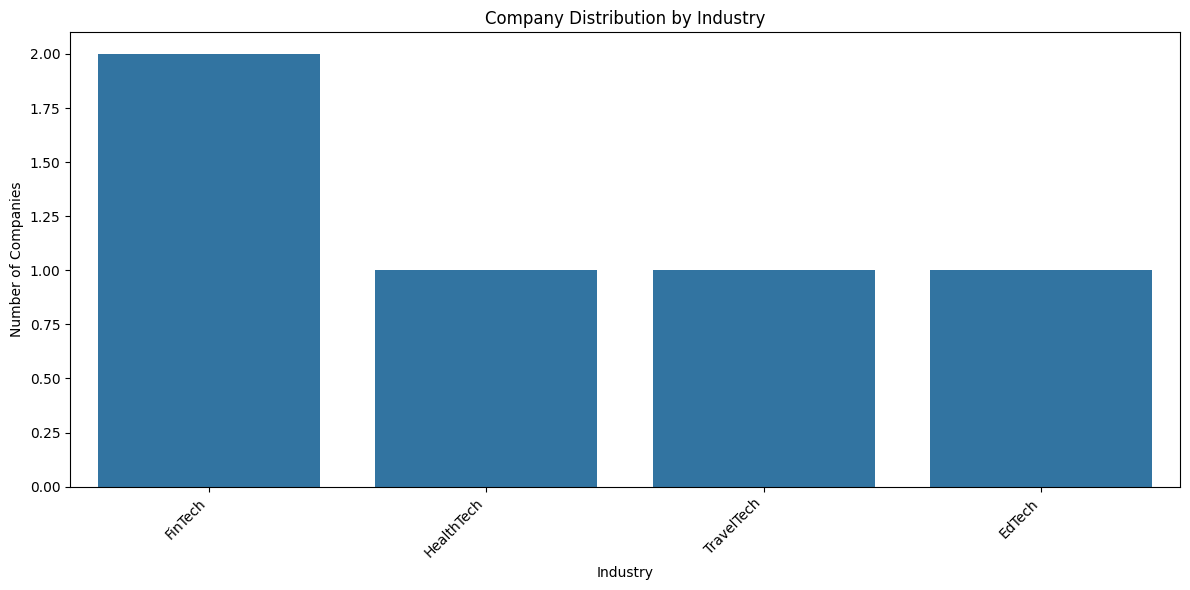

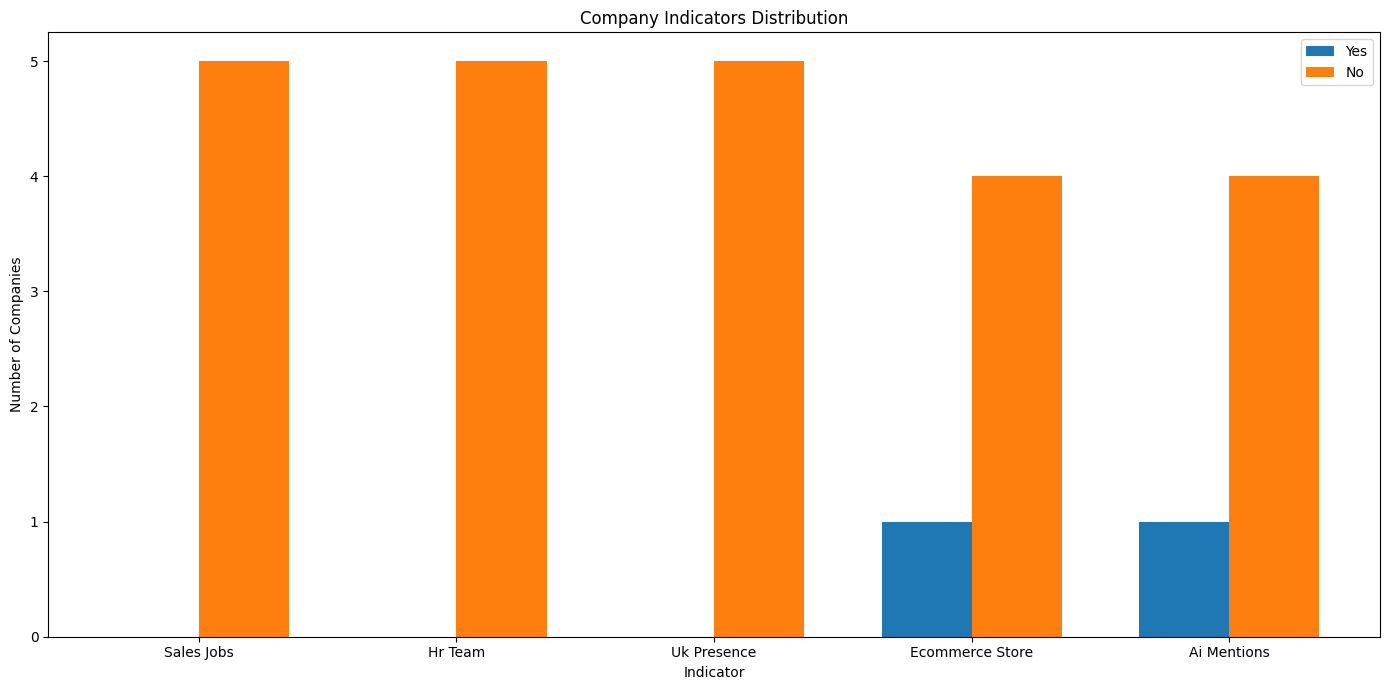

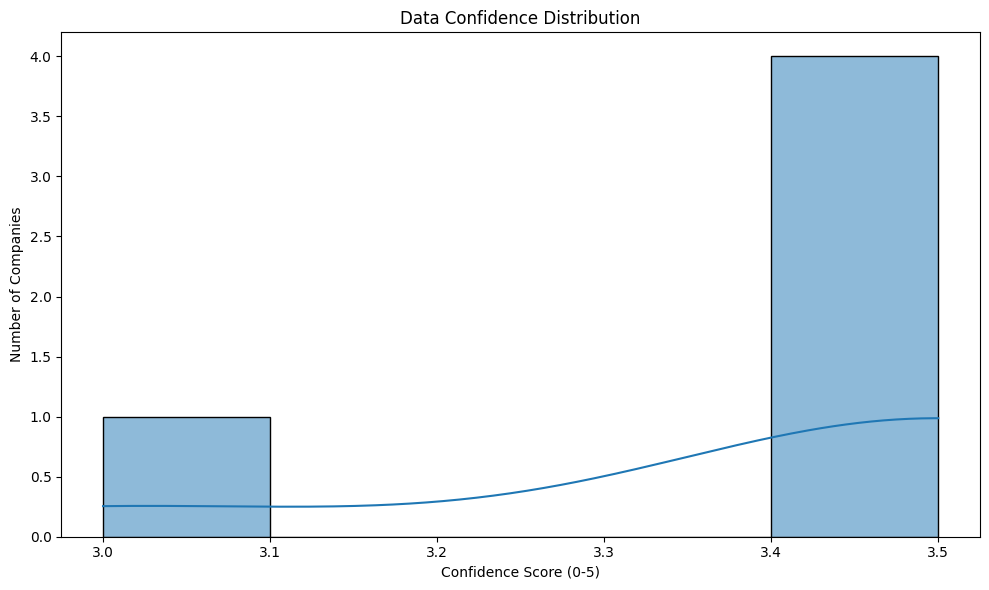


Step 4: Exporting enriched data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,company_name,company_domain,company_website,industry,location,detailed_industry,has_sales_jobs,has_hr_team,has_uk_presence,ecommerce_store,ai_mentions,data_confidence
0,TechNova Solutions,technova.com,https://www.technova.com,IT Services,San Francisco,FinTech,False,False,False,False,True,3.0
1,Green Leaf Organics,greenleaforganics.co.uk,https://www.greenleaforganics.co.uk,Agriculture,London,FinTech,False,False,False,True,False,3.5
2,MediHealth Systems,medihealthsystems.org,https://www.medihealthsystems.org,Healthcare,Boston,HealthTech,False,False,False,False,False,3.5
3,Global Travel Partners,globaltravelpartners.net,https://www.globaltravelpartners.net,Travel,New York,TravelTech,False,False,False,False,False,3.5
4,EduLearn Academy,edulearn.edu,https://www.edulearn.edu,Education,Chicago,EdTech,False,False,False,False,False,3.5



Enrichment process completed! Data saved to enriched_company_data.csv


In [ ]:
# Part 2: Data Loading
def load_company_data():
    """Load company data from CSV file uploaded by user"""
    print("Please upload your CSV file with company data...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        if filename.endswith('.csv'):
            df = pd.read_csv(filename)
        elif filename.endswith(('.xls', '.xlsx')):
            df = pd.read_excel(filename)
        else:
            raise ValueError("Unsupported file format. Please upload a CSV or Excel file.")

    required_columns = ['company_name']
    optional_columns = ['company_domain', 'company_website', 'industry', 'location']

    # Ensure required columns exist
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' is missing from the uploaded file.")

    # Add optional columns if missing
    for col in optional_columns:
        if col not in df.columns:
            df[col] = None

    # Add enrichment columns
    df['detailed_industry'] = None
    df['has_sales_jobs'] = None
    df['has_hr_team'] = None
    df['has_uk_presence'] = None
    df['ecommerce_store'] = None
    df['ai_mentions'] = None
    df['data_confidence'] = None

    print(f"Successfully loaded {len(df)} companies.")
    return df

# Part 3: Web Research Functions
def search_company(company_name, domain=None):
    """Search for company information online"""
    search_query = company_name
    if domain:
        search_query += f" {domain}"

    results = []

    if search_available:
        try:
            # First, try to get some results from DuckDuckGo
            search_results = ddgs.text(search_query, max_results=5)
            results = list(search_results)

            # If we have a domain, also search specifically on that domain
            if domain:
                site_results = ddgs.text(f"site:{domain}", max_results=3)
                results.extend(list(site_results))
        except Exception as e:
            print(f"Search error: {e}")

    if not results:
        print(f"No search results found for {company_name}")

    return results

def extract_website_info(url):
    """Extract text information from a website"""
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')

            # Remove scripts, styles, and other non-content tags
            for script in soup(["script", "style", "meta", "noscript", "header", "footer"]):
                script.extract()

            # Extract title
            title = soup.title.string if soup.title else ""

            # Extract meta description
            meta_desc = ""
            meta_tag = soup.find("meta", attrs={"name": "description"})
            if meta_tag and "content" in meta_tag.attrs:
                meta_desc = meta_tag["content"]

            # Extract main text content
            text = soup.get_text(separator=' ', strip=True)
            text = re.sub(r'\s+', ' ', text)  # Normalize whitespace

            # Extract potential "About" section
            about_section = ""
            about_headers = soup.find_all(["h1", "h2", "h3"], string=re.compile(r'about|company|who we are', re.I))
            for header in about_headers:
                section = []
                for sibling in header.find_next_siblings():
                    if sibling.name in ["h1", "h2", "h3"]:
                        break
                    section.append(sibling.get_text(strip=True))
                about_section += " ".join(section)

            return {
                "title": title,
                "meta_description": meta_desc,
                "about_section": about_section,
                "full_text": text[:5000],  # Limit to first 5000 chars
                "url": url
            }
        else:
            return {"error": f"Failed to fetch {url}: HTTP {response.status_code}"}
    except Exception as e:
        return {"error": f"Error processing {url}: {str(e)}"}

# Part 4: Industry Classification
def classify_industry(company_text):
    """Classify company industry based on text description"""

    # Dictionary of industry keywords
    industry_keywords = {
        "TravelTech": ["travel", "tourism", "booking", "flight", "hotel", "vacation", "destination"],
        "HRTech": ["recruitment", "talent", "hiring", "hr ", "human resources", "workforce", "staffing"],
        "FinTech": ["finance", "banking", "insurance", "payment", "financial", "loan", "invest"],
        "HealthTech": ["health", "medical", "healthcare", "patient", "doctor", "hospital", "clinic"],
        "EdTech": ["education", "learning", "teaching", "school", "student", "academic", "course"],
        "ECommerce": ["ecommerce", "online shop", "online store", "shopping", "retail", "marketplace"],
        "SaaS": ["software as a service", "saas", "subscription software", "cloud service"],
        "Manufacturing": ["manufacturing", "factory", "production", "industrial", "equipment"],
        "IT Services": ["it services", "consulting", "system integration", "tech support"],
        "AgTech": ["agriculture", "farming", "crop", "livestock", "agri-tech"]
    }

    # Count matches for each industry
    matches = {}
    company_text = company_text.lower()

    for industry, keywords in industry_keywords.items():
        count = sum(1 for keyword in keywords if keyword.lower() in company_text)
        if count > 0:
            matches[industry] = count

    # Return the industry with the most keyword matches
    if matches:
        return max(matches.items(), key=lambda x: x[1])[0]
    else:
        return "Unknown"

# Helper functions for specific indicators
def has_sales_jobs(company_text):
    """Detect if company has sales job openings"""
    sales_keywords = [
        "sales representative", "sales manager", "sales executive", "sales job",
        "hiring sales", "sales position", "sales opportunity", "sales career"
    ]
    return any(keyword in company_text.lower() for keyword in sales_keywords)

def has_hr_team(company_text):
    """Detect if company has an HR team"""
    hr_keywords = [
        "hr team", "human resources team", "recruiting team", "talent team",
        "head of hr", "hr manager", "hr department", "people operations"
    ]
    return any(keyword in company_text.lower() for keyword in hr_keywords)

def has_uk_presence(company_text):
    """Detect if company has UK presence"""
    uk_keywords = [
        "uk office", "united kingdom", "london office", "manchester", "birmingham",
        "uk team", "uk based", "offices in the uk", "uk headquarters"
    ]
    return any(keyword in company_text.lower() for keyword in uk_keywords)

def has_ecommerce(company_text):
    """Detect if company has an ecommerce store"""
    ecommerce_keywords = [
        "shop now", "add to cart", "buy online", "online store", "ecommerce",
        "shopping cart", "checkout", "product page", "online shop"
    ]
    return any(keyword in company_text.lower() for keyword in ecommerce_keywords)

def mentions_ai(company_text):
    """Detect if company mentions AI"""
    ai_keywords = [
        "artificial intelligence", "machine learning", "deep learning", "ai ",
        "neural network", "natural language processing", "nlp", "computer vision"
    ]
    return any(keyword in company_text.lower() for keyword in ai_keywords)

# Part 5: Main Enrichment Process
def enrich_company_data(df, max_companies=None):
    """Enrich company data with web research"""
    if max_companies:
        process_df = df.head(max_companies).copy()
    else:
        process_df = df.copy()

    for idx, row in process_df.iterrows():
        company_name = row['company_name']
        domain = row.get('company_domain', None)

        print(f"\nProcessing {company_name}...")

        # Search for company information
        search_results = search_company(company_name, domain)

        # Aggregate text from search results
        all_text = ""
        confidence = 0

        # If we have a domain, try to extract info directly from company website
        website_info = {}
        if domain and domain.startswith(('http://', 'https://')):
            website_info = extract_website_info(domain)
            if 'error' not in website_info:
                all_text += website_info.get('meta_description', '') + " "
                all_text += website_info.get('about_section', '') + " "
                all_text += website_info.get('full_text', '')
                confidence += 1

        # Process search results
        for i, result in enumerate(search_results):
            if isinstance(result, dict) and 'body' in result:
                all_text += result['body'] + " "
                confidence += 0.5

                # Try to extract more details from the first few results
                if i < 2 and 'href' in result:
                    site_info = extract_website_info(result['href'])
                    if 'error' not in site_info:
                        all_text += site_info.get('full_text', '')
                        confidence += 0.5

        # Perform analysis
        if all_text:
            # Classify industry
            detailed_industry = classify_industry(all_text)
            process_df.at[idx, 'detailed_industry'] = detailed_industry

            # Detect various indicators
            process_df.at[idx, 'has_sales_jobs'] = has_sales_jobs(all_text)
            process_df.at[idx, 'has_hr_team'] = has_hr_team(all_text)
            process_df.at[idx, 'has_uk_presence'] = has_uk_presence(all_text)
            process_df.at[idx, 'ecommerce_store'] = has_ecommerce(all_text)
            process_df.at[idx, 'ai_mentions'] = mentions_ai(all_text)

            # Set confidence score (0-5)
            process_df.at[idx, 'data_confidence'] = min(confidence, 5)
        else:
            print(f"No information found for {company_name}")
            process_df.at[idx, 'data_confidence'] = 0

        # Avoid rate limiting
        time.sleep(1)

    return process_df

# Part 6: Visualization Functions
def visualize_industries(df):
    """Visualize industry distribution"""
    plt.figure(figsize=(12, 6))
    industry_counts = df['detailed_industry'].value_counts()
    sns.barplot(x=industry_counts.index, y=industry_counts.values)
    plt.title('Company Distribution by Industry')
    plt.xlabel('Industry')
    plt.ylabel('Number of Companies')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def visualize_indicators(df):
    """Visualize binary indicators"""
    indicators = ['has_sales_jobs', 'has_hr_team', 'has_uk_presence', 'ecommerce_store', 'ai_mentions']
    valid_indicators = [col for col in indicators if col in df.columns]

    counts = {}
    for indicator in valid_indicators:
        true_count = df[indicator].sum()
        false_count = len(df) - true_count
        counts[indicator] = [true_count, false_count]

    plt.figure(figsize=(14, 7))
    x = np.arange(len(counts))
    width = 0.35

    # Plot
    plt.bar(x - width/2, [counts[ind][0] for ind in counts], width, label='Yes')
    plt.bar(x + width/2, [counts[ind][1] for ind in counts], width, label='No')

    plt.xlabel('Indicator')
    plt.ylabel('Number of Companies')
    plt.title('Company Indicators Distribution')
    plt.xticks(x, [ind.replace('_', ' ').replace('has ', '').title() for ind in counts.keys()])
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_confidence(df):
    """Visualize data confidence scores"""
    plt.figure(figsize=(10, 6))
    sns.histplot(df['data_confidence'], bins=5, kde=True)
    plt.title('Data Confidence Distribution')
    plt.xlabel('Confidence Score (0-5)')
    plt.ylabel('Number of Companies')
    plt.tight_layout()
    plt.show()

# Part 7: Run the complete workflow
def main():
    # 1. Load data
    print("Step 1: Loading company data")
    try:
        df = load_company_data()
    except Exception as e:
        print(f"Error loading data: {e}")
        # Create a sample dataframe for testing
        df = pd.DataFrame({
            'company_name': ['Acme Inc', 'TechCorp', 'Global Services', 'EduLearn', 'HealthPlus'],
            'company_domain': ['acme.com', 'techcorp.io', 'globalservices.net', 'edulearn.org', 'healthplus.com']
        })
        print("Created sample data for testing.")

    # 2. Confirm and limit for testing
    process_all = input("\nProcess all companies? (yes/no, default: limit to 5 for testing): ")
    max_companies = None if process_all.lower() == 'yes' else 5

    # 3. Enrich data
    print(f"\nStep 2: Enriching company data (processing {'all' if max_companies is None else max_companies} companies)")
    enriched_df = enrich_company_data(df, max_companies)

    # 4. Visualize results
    print("\nStep 3: Generating visualizations")
    visualize_industries(enriched_df)
    visualize_indicators(enriched_df)
    visualize_confidence(enriched_df)

    # 5. Export results
    print("\nStep 4: Exporting enriched data")
    output_filename = "enriched_company_data.csv"
    enriched_df.to_csv(output_filename, index=False)
    files.download(output_filename)

    # 6. Display results as HTML table
    display(HTML(enriched_df.to_html(classes='table table-striped')))

    print(f"\nEnrichment process completed! Data saved to {output_filename}")

# Run the main function when executed
if __name__ == "__main__":
    main()

# Usage Instructions:
# 1. Run this notebook
# 2. Upload a CSV with company data (must have 'company_name' column)
# 3. Choose whether to process all companies or just a test sample
# 4. Review the enriched data and visualizations
# 5. Download the enriched CSV